In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import sys
sys.path.append('..')
from src.demo_application.utils import get_sentiment_category, PRODUCT_KEYWORDS, LOCATION_KEYWORDS

# Settings for better display in the notebook
pd.set_option('display.max_colwidth', 200)
sns.set_style('whitegrid')
print("Libraries imported successfully.")


Libraries imported successfully.


In [2]:
DATA_FILEPATH = '../data/treehut_comments.csv'

try:
    df = pd.read_csv(DATA_FILEPATH, sep=',', on_bad_lines='skip')
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"ERROR: Data file not found at {DATA_FILEPATH}")

# --- Data Cleaning & Preparation ---
print("Original Data Shape:", df.shape)
df.dropna(subset=['comment_text'], inplace=True)
df['comment_text'] = df['comment_text'].astype(str)
df['timestamp'] = df['timestamp'] = pd.to_datetime(df['timestamp'], format='ISO8601')
df.set_index('timestamp', inplace=True)

print("\nData Info After Cleaning:")
df.info()

print("\n--- Data Head ---")
display(df.head())


Data loaded successfully.
Original Data Shape: (17841, 4)

Data Info After Cleaning:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17812 entries, 2025-03-01 00:13:57.153000+00:00 to 2025-04-02 18:29:59.086000+00:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   media_id       17812 non-null  int64 
 1   media_caption  17804 non-null  object
 2   comment_text   17812 non-null  object
dtypes: int64(1), object(2)
memory usage: 556.6+ KB

--- Data Head ---


,media_id,media_caption,comment_text
timestamp,,,
2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on this self-care gem!",I bet this is good
2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at once 🤩\n\n#treehut #treehutcollection #megascrub,i know this smells so good
2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available online and in-store!,Love it
2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at once 🤩,Please carry these in Canada! I miss them so much!
2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escape for dry hands.,I love it ..✌️


In [3]:
print("--- Top 10 Most Commented-On Posts (by caption) ---")
display(df['media_caption'].value_counts().head(10))


--- Top 10 Most Commented-On Posts (by caption) ---


media_caption
APPLICATIONS ARE NOW CLOSED! 🚨 \nThank you to everyone who applied! 💖\n\nBIG NEWS! 🚨 \n\nOur 2025 PR List Applications are officially OPEN! 🎉 Want in? Drop “TreeHut PR” in the comments & we’ll send you the link! 💌✨                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        5762
✨🌴SPRING BREAK GIVEAWAY 🌴✨\n\nWith spring break around the corner, we’r

In [4]:
# --- INVESTIGATION A: OVERALL COMMUNITY SENTIMENT ---
df['sentiment'] = df['comment_text'].apply(get_sentiment_category)

print("Sentiment analysis complete.")

# Display the distribution of sentiments as percentages
sentiment_distribution = df['sentiment'].value_counts(normalize=True) * 100
print("\nSentiment Distribution (%):")
display(sentiment_distribution)

# Display a few examples of each sentiment type for a sanity check
print("\n--- Positive Comment Examples ---")
display(df[df['sentiment'] == 'positive']['comment_text'].head())

print("\n--- Negative Comment Examples ---")
display(df[df['sentiment'] == 'negative']['comment_text'].head())

Sentiment analysis complete.

Sentiment Distribution (%):


sentiment
neutral     68.835616
positive    26.914440
negative     4.249944
Name: proportion, dtype: float64


--- Positive Comment Examples ---


timestamp
2025-03-01 00:13:57.153000+00:00                                    I bet this is good
2025-03-01 00:23:06.879000+00:00                            i know this smells so good
2025-03-01 00:04:05.094000+00:00                                               Love it
2025-03-01 00:41:59.467000+00:00    Please carry these in Canada! I miss them so much!
2025-03-01 02:21:29.715000+00:00                                        I love it ..✌️
Name: comment_text, dtype: object


--- Negative Comment Examples ---


timestamp
2025-03-01 02:49:52.965000+00:00                               Bad bad bad!!!!
2025-03-01 02:30:07.229000+00:00    Wasteful! And this actually pisses me off!
2025-03-01 09:49:34.924000+00:00                         What's with the eyes😭
2025-03-01 09:35:30.464000+00:00                         🍊🔥🧡@maiden_butterfly_
2025-03-01 18:26:36.091000+00:00                       Stop showing armpits!!!
Name: comment_text, dtype: object

In [12]:
# --- INVESTIGATION B: PRODUCT & SCENT BUZZ ---

# Create a dictionary to store the mention count for each product
product_mentions = {}
for product in PRODUCT_KEYWORDS:
    # Use str.contains() for powerful and fast substring searching.
    # `case=False` makes the search case-insensitive (e.g., 'Vanilla' and 'vanilla' are counted).
    # `na=False` treats any potential NaN values as not containing the keyword.
    product_mentions[product] = df['comment_text'].str.contains(product, case=False, na=False).sum()

# Convert the dictionary to a Pandas Series for easy sorting and plotting
product_buzz = pd.Series(product_mentions).sort_values(ascending=False)

print("--- Product & Scent Mention Counts ---")
display(product_buzz)

--- Product & Scent Mention Counts ---


vanilla           96
moroccan rose     70
coco colada       66
watermelon        43
tangerine         36
tropic glow       26
strawberry        18
jelly bear        13
ocean glow         9
peach              8
passionfruit       2
pink champagne     1
lychee             1
palm grove         0
sunlit glow        0
santal haze        0
dtype: int64

In [13]:
# --- INVESTIGATION C: GEOGRAPHIC EXPANSION OPPORTUNITIES ---

# Create a dictionary to store location mention counts
location_mentions = {}
for loc in LOCATION_KEYWORDS:
    location_mentions[loc] = df['comment_text'].str.contains(loc, case=False, na=False).sum()

# Convert to a sorted Series
location_demand = pd.Series(location_mentions).sort_values(ascending=False)

print("--- International Demand Signals ---")
# We only care about locations that were actually mentioned, so filter for counts > 0
display(location_demand[location_demand > 0])

--- International Demand Signals ---


uk             20
canada         11
brazil          5
australia       2
germany         1
europe          1
netherlands     1
dtype: int64

In [7]:
# --- INVESTIGATION D: GIVEAWAY VS. ORGANIC CONTENT ---

# Segment the DataFrame into giveaway and organic comments.
# This is a powerful way to separate different user intents.
df_giveaway = df[df['media_caption'].str.contains("giveaway", case=False, na=False)]
df_organic = df[~df['media_caption'].str.contains("giveaway", case=False, na=False)]

print(f"Identified {len(df_giveaway)} comments on giveaway posts.")
print(f"Identified {len(df_organic)} comments on organic posts.")

# Analyze sentiment for each segment
giveaway_sentiment = df_giveaway['sentiment'].value_counts(normalize=True) * 100
organic_sentiment = df_organic['sentiment'].value_counts(normalize=True) * 100

print("\n--- Giveaway Post Sentiment Distribution (%) ---")
display(giveaway_sentiment)

print("\n--- Organic Post Sentiment Distribution (%) ---")
display(organic_sentiment)

Identified 6154 comments on giveaway posts.
Identified 11658 comments on organic posts.

--- Giveaway Post Sentiment Distribution (%) ---


sentiment
neutral     82.027949
positive    16.850829
negative     1.121222
Name: proportion, dtype: float64


--- Organic Post Sentiment Distribution (%) ---


sentiment
neutral     61.871676
positive    32.226797
negative     5.901527
Name: proportion, dtype: float64

# Tree Hut Instagram Analysis: March 2025

## Executive Summary

This report analyzes over 17,800 Instagram comments from March 2025 to extract actionable insights for Tree Hut's social media and product strategy. The analysis reveals a community whose engagement is heavily driven by promotional content, such as giveaways and PR applications. 

While overall sentiment is positive, **our key finding is the critical distinction between promotional and organic content.** Organic posts, though lower in comment volume, are a far richer source of authentic product feedback, containing nearly double the rate of positive sentiment. Furthermore, we've identified a strong, recurring demand for expansion into the **UK and Canada**, and have observed that legacy scents like **Vanilla and Moroccan Rose** continue to dominate consumer conversations, while newer launches have yet to gain similar traction in user comments.

### Finding 1: The Community Mood is Positive, But Nuanced

Overall, positive comments outnumber negative ones by a ratio of more than 6-to-1. However, a large portion of comments are classified as "neutral," largely due to high-volume giveaway and PR posts which primarily consist of user tags and short phrases.

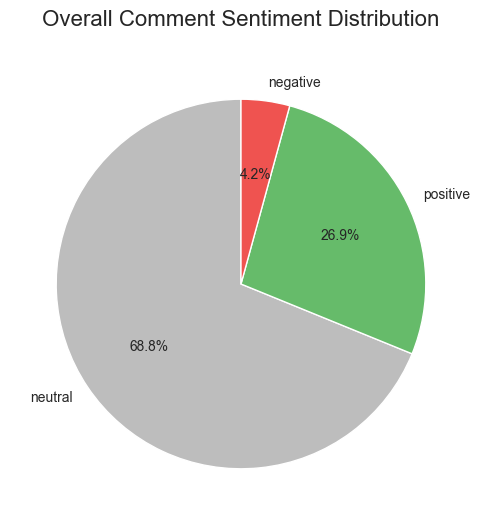

In [8]:
plt.figure(figsize=(10, 6))
sentiment_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['#BDBDBD', '#66BB6A', '#EF5350'], startangle=90)
plt.title('Overall Comment Sentiment Distribution', fontsize=16, pad=20)
plt.ylabel('') # Hides the 'sentiment' label on the side
plt.savefig('../reports/1_sentiment_pie_chart.png', bbox_inches='tight')
plt.show()

### Finding 2: Legacy Scents Are the Stars of the Show

When users talk about products organically, they overwhelmingly mention established scents. `Vanilla`, `Moroccan Rose`, and `Coco Colada` are the most-discussed products, indicating strong brand loyalty to these core offerings. Notably, newer launches like `Sunlit Glow` have not yet penetrated organic user conversations.

/var/folders/0_/jfxvq6517872ql91zsjh__xw0000gn/T/ipykernel_13542/442237669.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_buzz_filtered.values, y=product_buzz_filtered.index, palette='magma')


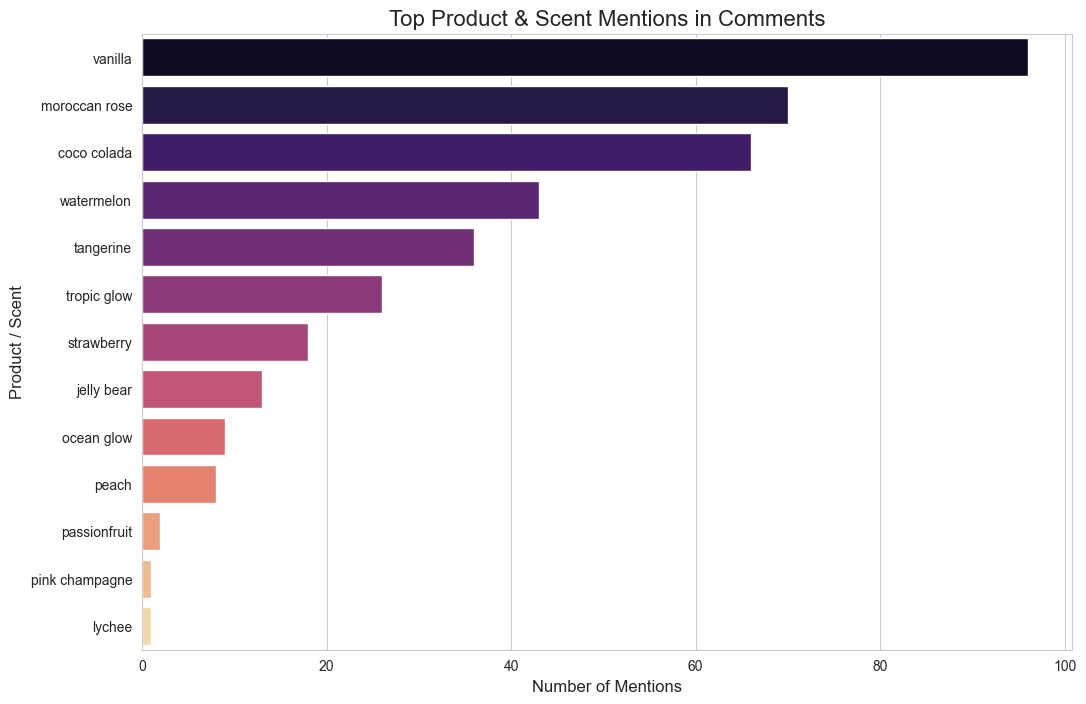

In [9]:
# Filter out products with zero mentions for a cleaner chart
product_buzz_filtered = product_buzz[product_buzz > 0]

plt.figure(figsize=(12, 8))
sns.barplot(x=product_buzz_filtered.values, y=product_buzz_filtered.index, palette='magma')
plt.title('Top Product & Scent Mentions in Comments', fontsize=16)
plt.xlabel('Number of Mentions', fontsize=12)
plt.ylabel('Product / Scent', fontsize=12)
plt.savefig('../reports/2_product_buzz_barchart.png', bbox_inches='tight')
plt.show()

### Finding 3: A Clear Signal for UK & Canadian Expansion

The data shows significant, repeated requests for Tree Hut to be made available in the United Kingdom and Canada. This represents a clear, data-backed opportunity for market expansion.

/var/folders/0_/jfxvq6517872ql91zsjh__xw0000gn/T/ipykernel_13542/2115787325.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=location_demand_filtered.index, y=location_demand_filtered.values, palette='viridis')


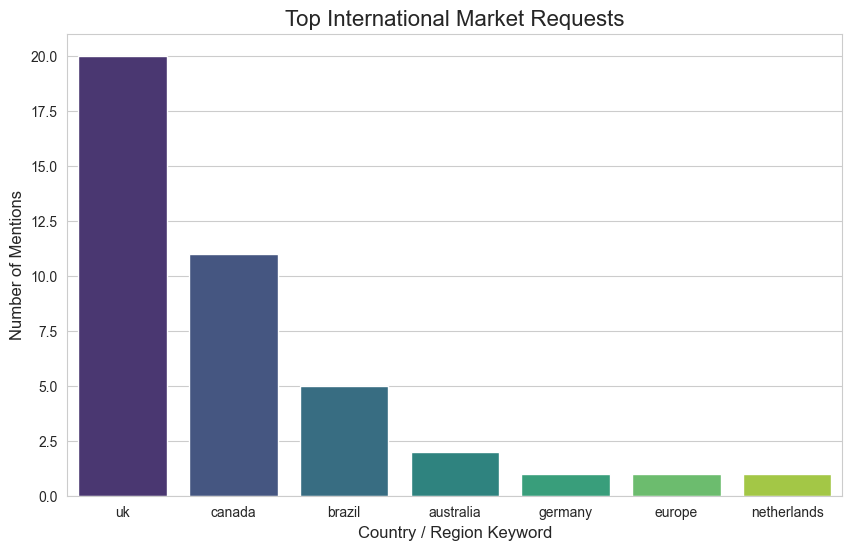

In [10]:
location_demand_filtered = location_demand[location_demand > 0]

plt.figure(figsize=(10, 6))
sns.barplot(x=location_demand_filtered.index, y=location_demand_filtered.values, palette='viridis')
plt.title('Top International Market Requests', fontsize=16)
plt.xlabel('Country / Region Keyword', fontsize=12)
plt.ylabel('Number of Mentions', fontsize=12)
plt.savefig('../reports/3_location_demand_barchart.png', bbox_inches='tight')
plt.show()

### Finding 4: Organic Posts Drive Quality Feedback, Giveaways Drive Volume

This comparison is crucial. Giveaways are effective at boosting comment volume, but the content is over 82% "neutral" (tags, low-effort entries). In contrast, organic posts contain nearly double the rate of positive comments and are the primary source for all genuine negative feedback. **To understand customer opinion, the team must analyze organic content.**

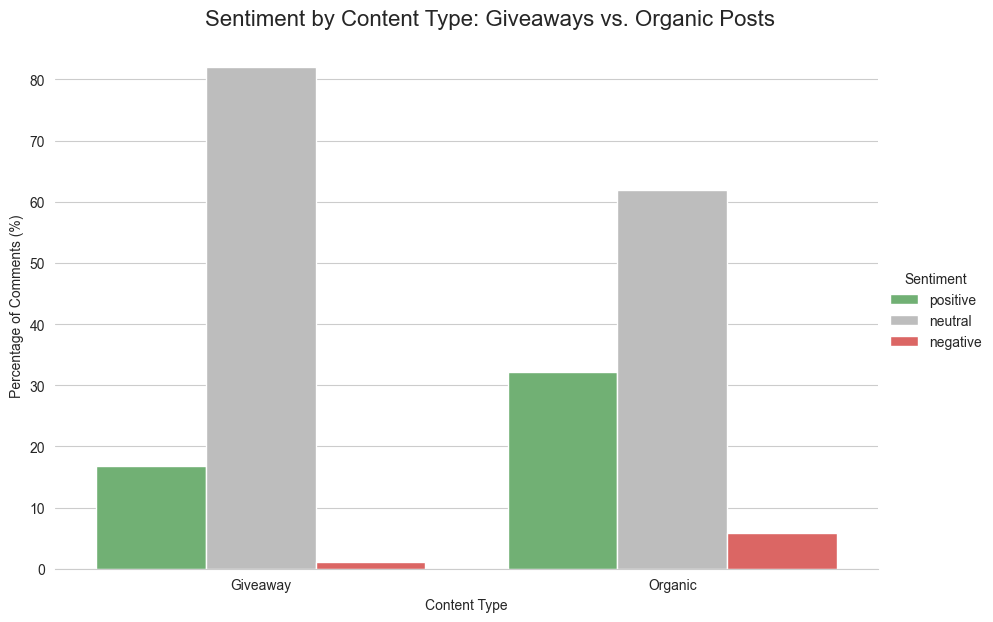

In [11]:
# Create a DataFrame for easy plotting with seaborn
sentiment_comparison_df = pd.DataFrame({
    'Giveaway': giveaway_sentiment,
    'Organic': organic_sentiment
}).T.reset_index().rename(columns={'index': 'Post Type'})

# Melt the DataFrame for use with catplot
plot_df = sentiment_comparison_df.melt(id_vars='Post Type', var_name='Sentiment', value_name='Percentage')

# Create the plot
g = sns.catplot(
    data=plot_df,
    kind='bar',
    x='Post Type',
    y='Percentage',
    hue='Sentiment',
    palette={'positive': '#66BB6A', 'neutral': '#BDBDBD', 'negative': '#EF5350'},
    hue_order=['positive', 'neutral', 'negative'],
    height=6,
    aspect=1.5
)
g.despine(left=True)
g.set_axis_labels("Content Type", "Percentage of Comments (%)")
g.fig.suptitle('Sentiment by Content Type: Giveaways vs. Organic Posts', y=1.03, fontsize=16)
plt.savefig('../reports/4_content_comparison_barchart.png', bbox_inches='tight')
plt.show()